<a href="https://colab.research.google.com/github/hyeonji-cho/Pytorch_Textbook/blob/main/ch5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5.2 합성곱 신경망 맛보기
### fashion_mnist 데이터셋 사용

#### 라이브러리 호출

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

#### CPU 혹은 GPU 장치 확인

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### fashion_mnist 데이터셋 내려받기

In [ ]:
train_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, transform=
                                                transforms.Compose([transforms.ToTensor()]))  # 이미지를 텐서로 변경
test_dataset  = torchvision.datasets.FashionMNIST("FashionMNIST/", download=True, train=False, transform=
                                               transforms.Compose([transforms.ToTensor()]))

100%|██████████| 26421880/26421880 [00:00<00:00, 119689684.45it/s]


Extracting FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 9342304.92it/s]

Extracting FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 55467587.28it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 24453314.83it/s]


Extracting FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to FashionMNIST/FashionMNIST/raw



#### fashion_mnist 데이터를 데이터로더에 전달

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=100)  # 100개 단위로 데이터를 묶어서 불러온다
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=100)

#### 분류에 사용될 클래스 정의

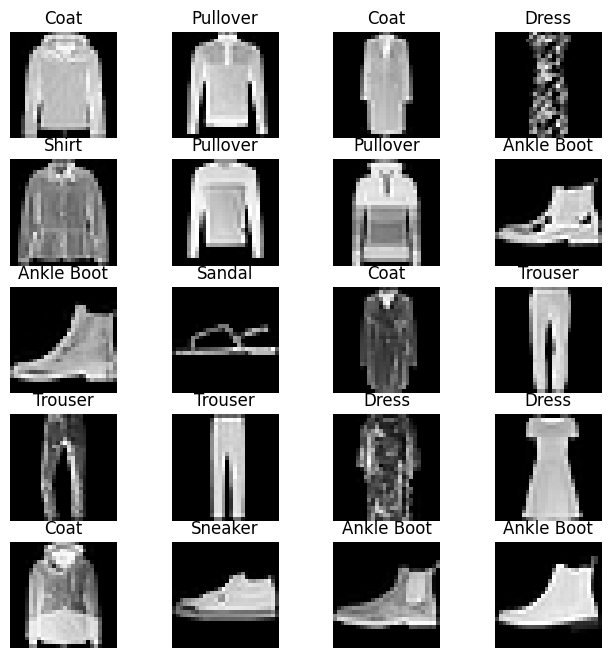

In [ ]:
labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'}

fig = plt.figure(figsize=(8,8));  # 8x8 사이즈의 플롯 생성
columns = 4;
rows = 5;

# 플롯에 이미지와 라벨 표시
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_dataset));  # 0에서 train_dataset 길이 사이의 임의의 숫자 생성
    img = train_dataset[img_xy][0][0,:,:]  # 선택된 인덱스의 이미지 (첫번째 채널에 해당하는 데이터)
    fig.add_subplot(rows, columns, i)  # i번째 위치에 subplot 추가
    plt.title(labels_map[train_dataset[img_xy][1]])  # 선택된 이미지의 라벨을 표시
    plt.axis('off')  # 축 제거
    plt.imshow(img, cmap='gray')  # 이미지를 흑백으로 표시
plt.show()

#### 심층 신경망 모델 생성

In [ ]:
class FashionDNN(nn.Module):
    # class 형태의 모델은 항상 torch.nn.Module을 상속받는다
    def __init__(self):  # __init__()은 객체가 갖는 속성 값 초기화, 객체가 생성될 때 자동으로 호출된다
        super(FashionDNN, self).__init__()  # nn.Module의 초기화 메서드 실행
        self.fc1 = nn.Linear(in_features=784,out_features=256)  # 단순 선형 회귀 모델
        self.drop = nn.Dropout2d(0.25)  # 0.25만큼의 비율로 텐서의 값이 0이 된다. 0.75에 해당하는 값은 (1/(1-0.75))만큼 커진다
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)

    def forward(self,input_data):  # 실제로 순전파 연산을 진행하는 함수
        out = input_data.view(-1, 784)  # 텐서의 크기를 (?,784)로 변경 -> 이미지 데이터를 펼쳐서 1차원 벡터로 변환한다
        out = F.relu(self.fc1(out))  # forward() 함수에서 활성화 함수 지정
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

#### 심층 신경망에서 필요한 파라미터 정의 (손실 함수, 학습률, 옵티마이저)

In [ ]:
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();  # 손실 함수
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);  # 옵티마이저 - 경사하강법:Adam, 학습률:0.001
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


#### 모델 학습

In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):  # 레코드(행)을 하나씩 가져온다
    for images, labels in train_loader:  # 레코드에서 images, labels 2개를 꺼내온다
        images, labels = images.to(device), labels.to(device)  # 모델과 데이터가 동일한 장치에 있어야 한다

        # Variable 객체
        # 역전파를 위한 미분 값을 자동 계산
        train = Variable(images.view(100, 1, 28, 28))  # 배치사이즈, 채널수, 높이, 너비
        labels = Variable(labels)

        outputs = model(train)  # 학습 데이터를 모델에 적용
        loss = criterion(outputs, labels)
        optimizer.zero_grad()  # 기울기를 초기화
        loss.backward()
        optimizer.step()  # 모델의 파라미터를 업데이트
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total  # 정확도
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.6190640926361084, Accuracy: 82.90999603271484%
Iteration: 1000, Loss: 0.5032315254211426, Accuracy: 84.98999786376953%
Iteration: 1500, Loss: 0.3605240285396576, Accuracy: 84.43000030517578%
Iteration: 2000, Loss: 0.3780788481235504, Accuracy: 85.12999725341797%
Iteration: 2500, Loss: 0.2996842563152313, Accuracy: 85.79000091552734%
Iteration: 3000, Loss: 0.291736900806427, Accuracy: 86.5999984741211%


#### 합성곱 신경망 생성

In [ ]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(  # 여러 개의 계층을 하나의 컨테이너에 구현
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),  # 흑백이라 입력채널 1, (100,32,28,28)
            nn.BatchNorm2d(32),  # 평균 0, 표준편차 1로 정규화
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 이미지 크기 축소, (100,32,14,14)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),  # (100,64,12,12)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)  # 이전 레이어의 출력 크기를 절반으로 줄임, (100,64,6,6)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)  # 1차원 배열 형태로 변환
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)  # (100,32,14,14)
        out = self.layer2(out)  # (100,64,6,6)
        out = out.view(out.size(0), -1)  # (100,64*6*6=2304)
        out = self.fc1(out)  # (100,600)
        out = self.drop(out)
        out = self.fc2(out)  # (100,120)
        out = self.fc3(out)  # (100,10)
        return out


#### 합성곱 네트워크를 위한 파라미터 정의

In [ ]:
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


#### 모델 학습 및 성능 평가

In [ ]:
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        train = Variable(images.view(100, 1, 28, 28))
        labels = Variable(labels)

        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1

        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100, 1, 28, 28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)

            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)

        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

Iteration: 500, Loss: 0.4843355417251587, Accuracy: 87.1199951171875%
Iteration: 1000, Loss: 0.262457013130188, Accuracy: 88.61000061035156%
Iteration: 1500, Loss: 0.28579556941986084, Accuracy: 88.93999481201172%
Iteration: 2000, Loss: 0.18356141448020935, Accuracy: 89.5999984741211%
Iteration: 2500, Loss: 0.12069795280694962, Accuracy: 89.31999969482422%
Iteration: 3000, Loss: 0.24565014243125916, Accuracy: 90.29000091552734%
